In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [13]:
# Load the cleaned and preprocessed dataset
# Make sure to replace 'your_CLEANED_brca_data.csv' with your actual file name
df_clean = pd.read_csv('p2-cleaned-data.csv')

# Display the shape and a sample to confirm it's the correct data
print("Cleaned Dataset Shape:", df_clean.shape)
print("\nFirst 5 Rows:")
print(df_clean.head())

# Confirm the target column 'subtype' is present and see its distribution
print("\nSubtype Distribution:")
print(df_clean['subtype'].value_counts())

Cleaned Dataset Shape: (507, 1941)

First 5 Rows:
   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554   
4  12.964607   6.806517   4.294341   5.385714  ...          -0.441542   

   pp_p70S6K  pp_p70S6K.pT389  pp_p90RSK  pp_p90RSK.pT359.S363  PR.Statu

In [14]:
# The target variable (y) is the 'subtype' column
y = df_clean['subtype']

# The features (X) are all the omics columns
# These are columns starting with 'rs_', 'cn_', 'mu_', or 'pp_'
feature_columns = [col for col in df_clean.columns if col.startswith(('rs_', 'cn_', 'mu_', 'pp_'))]
X = df_clean[feature_columns]

# Even in clean data, feature columns can have missing values.
# We will use an imputer to fill any potential NaNs with the median value of their column.
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (507, 1936)
Target (y) shape: (507,)


In [26]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=37,  # for reproducibility
    stratify=y        # important for imbalanced classes
)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 405
Testing set size: 102


In [16]:
# Define the parameter grid to search
# These parameters help prevent overfitting by controlling the tree's complexity
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],      # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Min samples required at a leaf node
}

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
# cv=5 means we will use 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores to speed up the search
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

print("GridSearchCV is set up. Ready to find the best parameters.")

GridSearchCV is set up. Ready to find the best parameters.


In [17]:
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the search
print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Get the best estimator (the best model)
best_dt_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Parameters found by GridSearchCV:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}



Optimized Model Accuracy: 83.33%

Optimized Classification Report:
                           precision    recall  f1-score   support

            HER2-enriched       0.69      0.65      0.67        17
HR-positive/HER2-negative       0.88      0.90      0.89        67
          Triple-Negative       0.78      0.78      0.78        18

                 accuracy                           0.83       102
                macro avg       0.78      0.77      0.78       102
             weighted avg       0.83      0.83      0.83       102

Optimized Confusion Matrix:


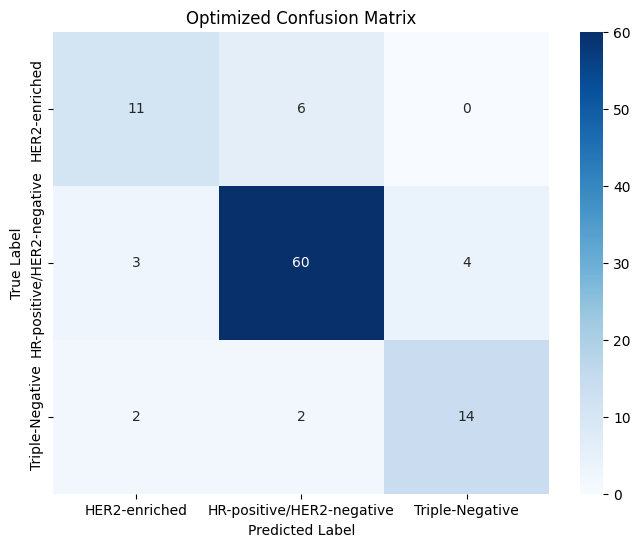

In [18]:
# Make predictions on the test set using the best model
y_pred_optimized = best_dt_classifier.predict(X_test)

# Calculate the new accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"\nOptimized Model Accuracy: {accuracy_optimized * 100:.2f}%\n")

# Print a detailed classification report
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))

# Generate and display the new confusion matrix
print("Optimized Confusion Matrix:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_dt_classifier.classes_,
            yticklabels=best_dt_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Optimized Confusion Matrix')
plt.show()

In [21]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [22]:
print(df_clean['subtype'].value_counts())

subtype
HR-positive/HER2-negative    335
Triple-Negative               90
HER2-enriched                 82
Name: count, dtype: int64


In [23]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'subtype' column
df_clean['subtype_encoded'] = label_encoder.fit_transform(df_clean['subtype'])

# Display the mapping of text labels to integer codes
print("Label Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")

# Verify the new column
print("\nEncoded Subtype Distribution:")
print(df_clean['subtype_encoded'].value_counts())

Label Encoding Mapping:
HER2-enriched -> 0
HR-positive/HER2-negative -> 1
Triple-Negative -> 2

Encoded Subtype Distribution:
subtype_encoded
1    335
2     90
0     82
Name: count, dtype: int64


In [28]:
# The target variable (y) is the new encoded column
y = df_clean['subtype_encoded']

# The features (X) are all the omics columns
feature_columns = [col for col in df_clean.columns if col.startswith(('rs_', 'cn_', 'mu_', 'pp_'))]
X = df_clean[feature_columns]

# Impute any missing feature values with the median
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (507, 1936)
Target (y) shape: (507,)


In [30]:
# Step 1: Split data into training+validation (80%) and test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=37, stratify=y
)

# Step 2: Split the training+validation set into final training (80% of the 80%) and validation (20% of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=37, stratify=y_train_full # 0.25 * 0.8 = 0.2
)

print(f"Total data shape: {X.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Total data shape: (507, 1936)
Training set shape: (303, 1936)
Validation set shape: (102, 1936)
Test set shape: (102, 1936)


C:\Users\samee\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:48:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


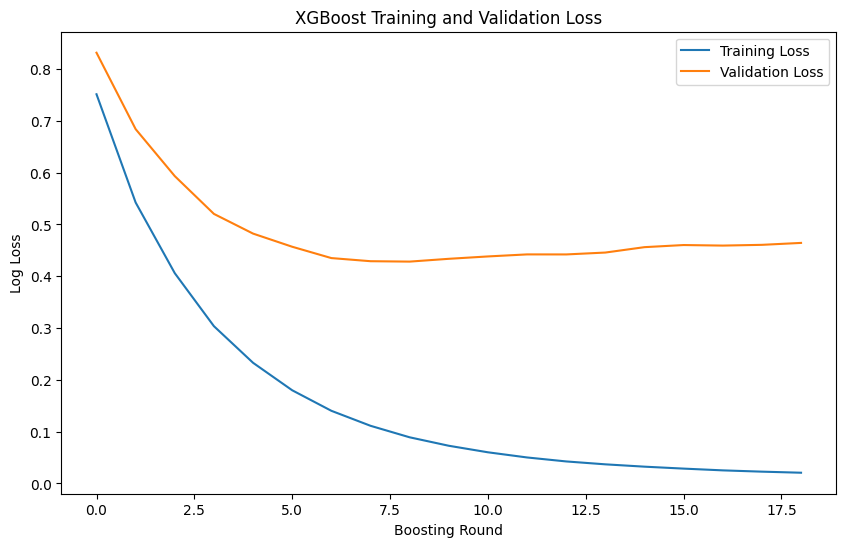

In [47]:
# Initialize and train the model
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss', # We are explicitly telling it to track mlogloss
    use_label_encoder=False,
    random_state=37,
    early_stopping_rounds=10,

)

# The history is stored during the fit process
xgb_classifier.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)], # Track loss on both train and validation
                   verbose=False)

# --- Plotting the Loss ---
results = xgb_classifier.evals_result()
train_loss = results['validation_0']['mlogloss']
val_loss = results['validation_1']['mlogloss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('XGBoost Training and Validation Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

Model Accuracy on VALIDATION Set: 85.29%

--------------------------------------------------
Model Accuracy on FINAL TEST Set: 87.25%

Final Classification Report on Test Set:
                           precision    recall  f1-score   support

            HER2-enriched       0.86      0.71      0.77        17
HR-positive/HER2-negative       0.90      0.93      0.91        67
          Triple-Negative       0.79      0.83      0.81        18

                 accuracy                           0.87       102
                macro avg       0.85      0.82      0.83       102
             weighted avg       0.87      0.87      0.87       102


Final Confusion Matrix on Test Set:


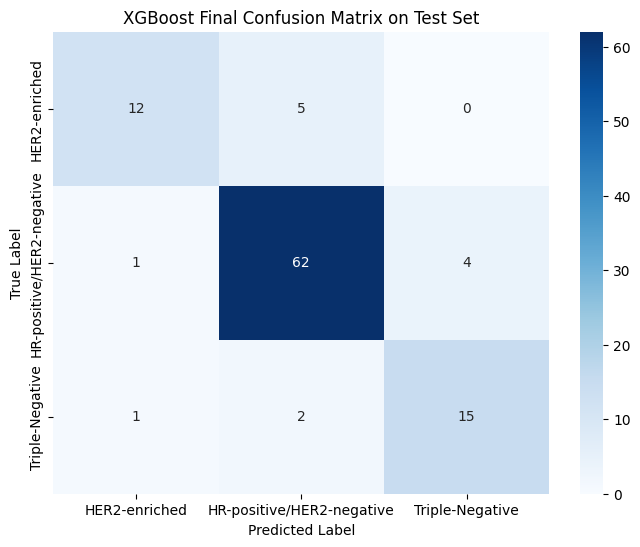

In [48]:
# --- Evaluation on Validation Set ---
# Make predictions on the validation set
y_pred_val = xgb_classifier.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Model Accuracy on VALIDATION Set: {accuracy_val * 100:.2f}%\n")
print("-" * 50)

# --- Final Evaluation on the Unseen Test Set ---
# Make predictions on the final, unseen test set
y_pred_test = xgb_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Model Accuracy on FINAL TEST Set: {accuracy_test * 100:.2f}%\n")

# Print a detailed classification report for the FINAL TEST set
print("Final Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

# Generate and display the confusion matrix for the FINAL TEST set
print("\nFinal Confusion Matrix on Test Set:")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Final Confusion Matrix on Test Set')
plt.show()

In [ ]:
# Define the parameter grid
# We are testing a range of values for both L2 (lambda) and L1 (alpha) regularization
param_grid = {
    'reg_lambda': [0.1, 1, 10, 50, 100],
    'reg_alpha': [0, 0.1, 1, 10],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=37
)

# Initialize and run GridSearchCV
# This will find the best combination of parameters from the grid
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to your full training data
grid_search.fit(X_train_full, y_train_full)

# Print the best parameters found
print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=700, random_state=37)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

print("Random Forest model trained successfully!")

Random Forest model trained successfully!


Random Forest Accuracy on VALIDATION Set: 84.31%

--------------------------------------------------
Random Forest Accuracy on FINAL TEST Set: 85.29%

Final Classification Report on Test Set:
                           precision    recall  f1-score   support

            HER2-enriched       0.83      0.59      0.69        17
HR-positive/HER2-negative       0.86      0.94      0.90        67
          Triple-Negative       0.82      0.78      0.80        18

                 accuracy                           0.85       102
                macro avg       0.84      0.77      0.80       102
             weighted avg       0.85      0.85      0.85       102


Final Confusion Matrix on Test Set:


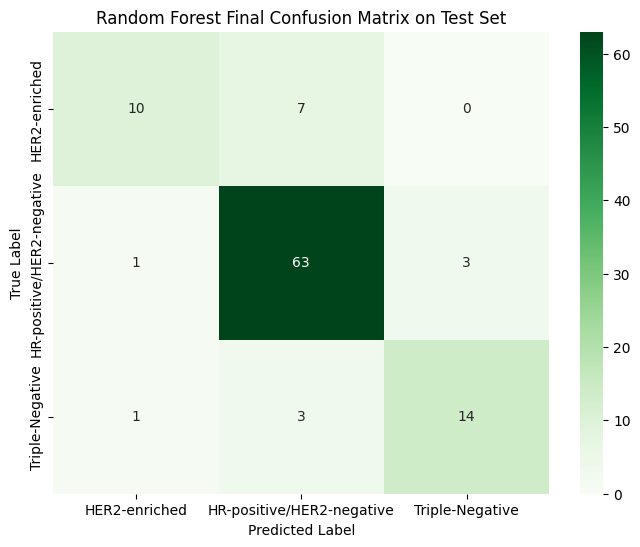

In [43]:
# --- Evaluation on Validation Set ---
y_pred_val_rf = rf_classifier.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Random Forest Accuracy on VALIDATION Set: {accuracy_val_rf * 100:.2f}%\n")
print("-" * 50)

# --- Final Evaluation on the Unseen Test Set ---
y_pred_test_rf = rf_classifier.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Random Forest Accuracy on FINAL TEST Set: {accuracy_test_rf * 100:.2f}%\n")

# Print a detailed classification report for the FINAL TEST set
print("Final Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test_rf, target_names=label_encoder.classes_))

# Generate and display the confusion matrix for the FINAL TEST set
print("\nFinal Confusion Matrix on Test Set:")
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Final Confusion Matrix on Test Set')
plt.show()

In [49]:
df_clean.head()

,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,PR.Status,ER.Status,HER2.Final.Status,histological.type,subtype,subtype_encoded
0,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.338490,10.248379,10.229970,...,-0.337863,-0.178503,0.011638,-0.207257,Positive,Positive,Negative,infiltrating ductal carcinoma,HR-positive/HER2-negative,1
1,0.000000,3.691311,17.116090,15.517231,9.867616,9.691667,8.179522,7.911723,1.289598,1.818891,...,0.292925,-0.155242,-0.089365,0.267530,Positive,Negative,Negative,infiltrating ductal carcinoma,HR-positive/HER2-negative,1
2,3.748150,4.375255,9.658123,5.326983,12.109539,11.644307,10.517330,5.114925,11.975349,11.911437,...,0.308110,-0.190794,-0.222150,-0.198518,Positive,Positive,Negative,infiltrating ductal carcinoma,HR-positive/HER2-negative,1
3,0.000000,18.235519,18.535480,14.533584,14.078992,8.913760,10.557465,13.304434,8.205059,9.211476,...,-0.079871,-0.463237,0.522998,-0.046902,Positive,Positive,Negative,infiltrating ductal carcinoma,HR-positive/HER2-negative,1
4,0.000000,4.583724,15.711865,12.804521,8.881669,8.430028,12.964607,6.806517,4.294341,5.385714,...,-0.152317,0.511386,-0.096482,0.037473,Positive,Positive,Negative,infiltrating ductal carcinoma,HR-positive/HER2-negative,1
